In [1]:
from huggingface_hub import snapshot_download

In [2]:
model_dir = snapshot_download(repo_id="MONAI/wholeBody_ct_segmentation", local_dir="../models/monai_seg")
print("📥 Model pobrany do:", model_dir)

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

📥 Model pobrany do: /home/mateusz/PW/INZ/vertabrae_cls/models/monai_seg


In [62]:
import os
import torch
from monai.bundle import ConfigParser

# Ścieżka do katalogu z pobranym modelem MONAI Bundle
model_dir = "../models/monai_seg"
model_file = "models/model.pt"  # zakładamy, że w folderze models jest plik model.pt

# Wczytanie konfiguracji inferencji z bundle (określa m.in. architekturę sieci i transformacje)
config_path = os.path.join(model_dir, "configs", "inference.json")
parser = ConfigParser()
parser.read_config(config_path)

# Utworzenie modelu zgodnie z konfiguracją (znalezienie definicji sieci w configu)
model = parser.get_parsed_content("network_def")
# Załadowanie wag modelu
weights = torch.load(os.path.join(model_dir, model_file), map_location="cpu")
# Jeśli wagi są zapisane pod kluczem "state_dict", wyciągnij go:
if isinstance(weights, dict) and "state_dict" in weights:
    weights = weights["state_dict"]
model.load_state_dict(weights)
model.eval()


SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, a

In [91]:
param_size = 0
for param in model.parameters():
    param_size += param.numel() * param.element_size()
print("Rozmiar modelu:", param_size / 1024 / 1024, "MB")

Rozmiar modelu: 71.71402359008789 MB


# v1


In [4]:
import nrrd
import torch

data, header = nrrd.read("/home/mateusz/Documents/aa.nrrd")



In [5]:

import numpy as np

data = np.clip(data, -1000, 1000)
data = (data + 1000) / 2000.0
data = np.clip(data, 0.0, 1.0)

In [7]:
tensor = torch.tensor(data)

In [8]:
tensor.shape

torch.Size([512, 512, 859])

In [9]:
print(header)

OrderedDict({'type': 'short', 'dimension': 3, 'space': 'left-posterior-superior', 'sizes': array([512, 512, 859]), 'space directions': array([[0.48828125, 0.        , 0.        ],
       [0.        , 0.48828125, 0.        ],
       [0.        , 0.        , 0.45      ]]), 'kinds': ['domain', 'domain', 'domain'], 'endian': 'little', 'encoding': 'gzip', 'space origin': array([-169.  ,   71.3 ,   59.58])})


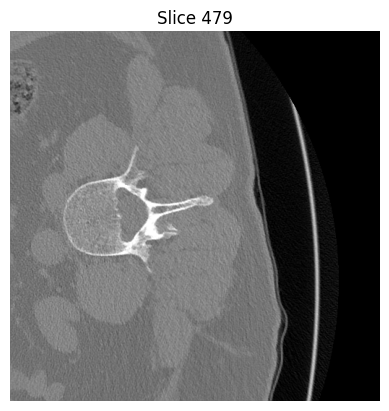

In [10]:
import matplotlib.pyplot as plt

# Zbadaj środkową slicę
x_middle = tensor.shape[2] // 2 +50

plt.imshow(tensor[:, :, x_middle], cmap='gray')
plt.title(f"Slice {x_middle}")
plt.axis('off')
plt.show()

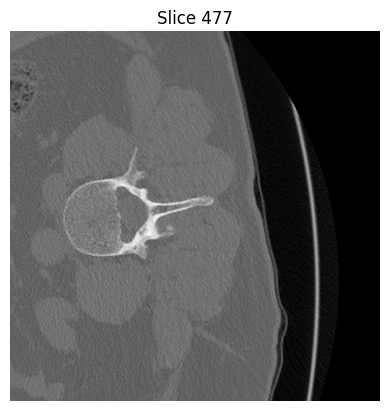

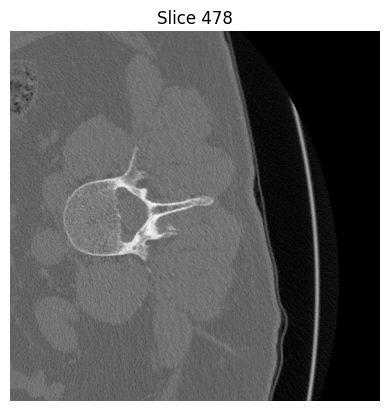

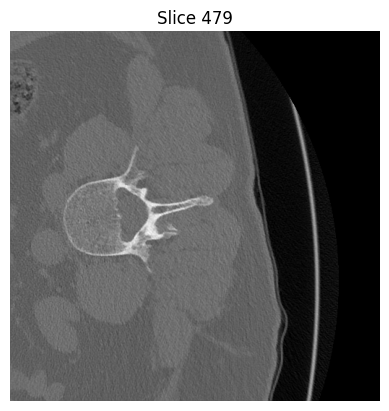

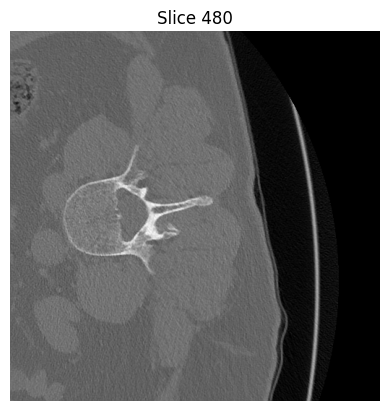

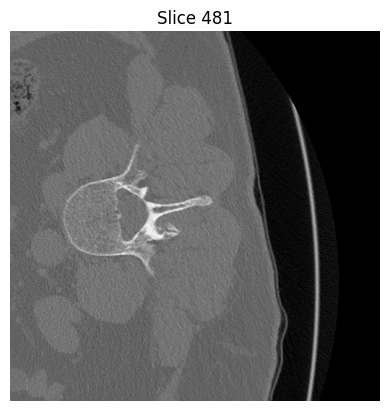

In [24]:
for i in range(x_middle - 2, x_middle + 3):
    plt.imshow(tensor[:, :, i], cmap='gray')
    plt.title(f"Slice {i}")
    plt.axis('off')
    plt.show()

In [12]:
import torch.nn.functional as F

tensor = torch.tensor(data, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).unsqueeze(0)

tensor_small = F.interpolate(tensor, size=(300, 256, 256), mode="trilinear", align_corners=False)
tensor.shape, tensor_small.shape


(torch.Size([1, 1, 859, 512, 512]), torch.Size([1, 1, 300, 256, 256]))

In [13]:
from monai.bundle import ConfigParser
import numpy as np
from monai.inferers import sliding_window_inference

model_dir = "../models/monai_seg"  # zmień na swoją ścieżkę
config_file = f"{model_dir}/configs/inference.json"

parser = ConfigParser()
parser.read_config(config_file)
parser.parse()

model = parser.get_parsed_content("network_def")
weights = torch.load(f"{model_dir}/models/model.pt", map_location="cpu")
model.load_state_dict(weights["state_dict"] if "state_dict" in weights else weights)
model.eval()


with torch.no_grad():
    sw_batch_size = 1
    output = sliding_window_inference(
    tensor_small, roi_size=(64, 64, 64), sw_batch_size=1, predictor=model, overlap=0, sw_device="cpu"
)

# 6. Uzyskaj predykcję klasową
pred_labels = torch.argmax(output, dim=1)  # (1, D, H, W)
segmentation_map = pred_labels[0].cpu().numpy().astype(np.uint8)

print("✅ Segmentacja zakończona:", segmentation_map.shape)

✅ Segmentacja zakończona: (300, 256, 256)


In [ ]:
spine_labels = list(range(18, 42))

# Maska voxeli należących do kręgów
spine_mask = np.isin(segmentation_map, spine_labels)
spine_segmentation = segmentation_map.copy()
spine_segmentation[~spine_mask] = 0  # wyzerowanie wszystkiego poza kręgami

# Znajdź unikalne etykiety kręgów obecne w segmencie (pomijając 0)
unique_spine_labels = [lbl for lbl in np.unique(spine_segmentation) if lbl != 0]
print(f"Wykryte etykiety kręgów w skanie: {unique_spine_labels}")
hist = 

Wykryte etykiety kręgów w skanie: [18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]


In [27]:
from collections import Counter 

hist = Counter(spine_segmentation.flatten())

In [28]:
hist

Counter({0: 19648405,
         41: 2786,
         18: 2556,
         40: 1926,
         35: 1151,
         34: 1043,
         39: 777,
         37: 772,
         33: 552,
         36: 199,
         28: 181,
         21: 96,
         38: 85,
         20: 73,
         23: 45,
         22: 36,
         32: 31,
         27: 25,
         24: 22,
         31: 20,
         29: 17,
         19: 2})

In [15]:
spine_segmentation.shape

(300, 256, 256)

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def view_slice(slice_idx):
    plt.figure(figsize=(6, 6))
    plt.imshow(spine_segmentation[slice_idx, :, :], cmap='gray')
    plt.title(f"Slice {slice_idx}")
    plt.axis('off')
    plt.show()

slider = widgets.IntSlider(min=0, max=spine_segmentation.shape[0] - 1, step=1, value=spine_segmentation.shape[0] // 2)
widgets.interact(view_slice, slice_idx=slider)

# V2

In [4]:
import xml.etree.ElementTree as ET
from pathlib import Path

nrrd_paths = list(Path("../data/nrrd/MM").glob("*.nrrd"))
nrrd_paths

[PosixPath('../data/nrrd/MM/202 KOSCI iDose (4).nrrd'),
 PosixPath('../data/nrrd/MM/201 MIEKKIE.nrrd'),
 PosixPath('../data/nrrd/MM/100 Unnamed Series.nrrd')]

In [13]:
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd, ScaleIntensityRanged, EnsureTyped

transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    Spacingd(keys=["image"], pixdim=(3.0, 3.0, 3.0), mode=("bilinear")),
    Orientationd(keys=["image"], axcodes="RAS"),
    ScaleIntensityRanged(
        keys=["image"],
        a_min=-1024,
        a_max=2048,
        b_min=0.0,
        b_max=1.0,
        clip=True,
    ),
    EnsureTyped(keys=["image"]),
])

In [14]:
# Zastosuj transformacje
data = {"image": nrrd_paths[0]}
transformed = transforms(data)



In [16]:
print(type(transformed["image"]))       # torch.Tensor
print(transformed["image"].shape)  

<class 'monai.data.meta_tensor.MetaTensor'>
torch.Size([1, 84, 84, 130])


In [17]:
input_tensor = transformed["image"].unsqueeze(0)  

In [18]:
from monai.inferers import sliding_window_inference

model.eval()
with torch.no_grad():
    output = sliding_window_inference(
        inputs=input_tensor,
        roi_size=(96, 96, 96),  # zmień na mniejsze np. (64, 64, 64) jeśli za dużo RAM
        sw_batch_size=1,
        predictor=model,
        overlap=0.5,
        mode="gaussian"
    )

In [21]:
output.shape

torch.Size([1, 105, 84, 84, 130])

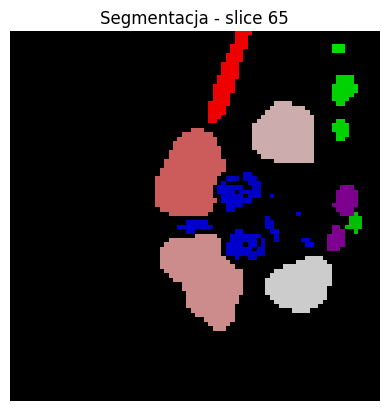

In [20]:
import matplotlib.pyplot as plt

# Załóżmy że output ma kształt (1, C, D, H, W)
output_np = output.argmax(dim=1).squeeze().cpu().numpy()  # (D, H, W)

z = output_np.shape[2] // 2  # środkowy slice

plt.imshow(output_np[:, :, z], cmap="nipy_spectral")
plt.title(f"Segmentacja - slice {z}")
plt.axis("off")
plt.show()

In [22]:
vertebra_labels = {
    18: "L5", 19: "L4", 20: "L3", 21: "L2", 22: "L1",
    23: "T12", 24: "T11", 25: "T10", 26: "T9", 27: "T8", 28: "T7",
    29: "T6", 30: "T5", 31: "T4", 32: "T3", 33: "T2", 34: "T1",
    35: "C7", 36: "C6", 37: "C5", 38: "C4", 39: "C3", 40: "C2", 41: "C1"
}


In [39]:
segmentation = output.argmax(dim=1).squeeze().cpu().numpy()  # shape: (D, H, W)

# Policz unikalne etykiety i ile ich jest
labels, counts = np.unique(segmentation, return_counts=True)

# Pokaż w formie słownika
label_counts = dict(zip(labels, counts))

# Posortowane i wypisane
for label, count in sorted(label_counts.items(), key=lambda x: -x[1]):
    print(f"Label {label:>2}: {count} voxeli")

Label  0: 654997 voxeli
Label 100: 23753 voxeli
Label 101: 21406 voxeli
Label 94: 16571 voxeli
Label 95: 15653 voxeli
Label 104: 15584 voxeli
Label 91: 15379 voxeli
Label 90: 14943 voxeli
Label 55: 13441 voxeli
Label 102: 13401 voxeli
Label  5: 11717 voxeli
Label 92: 11640 voxeli
Label 103: 10681 voxeli
Label  2: 8003 voxeli
Label  3: 7840 voxeli
Label 97: 4993 voxeli
Label 96: 4929 voxeli
Label 57: 4686 voxeli
Label  1: 4359 voxeli
Label 21: 4231 voxeli
Label  7: 3938 voxeli
Label 89: 3675 voxeli
Label 88: 3104 voxeli
Label 18: 2966 voxeli
Label 20: 2826 voxeli
Label 22: 2587 voxeli
Label 19: 2523 voxeli
Label 23: 2193 voxeli
Label  8: 2020 voxeli
Label 10: 1984 voxeli
Label 53: 1811 voxeli
Label 56: 1440 voxeli
Label 99: 1415 voxeli
Label 24: 1259 voxeli
Label 54: 794 voxeli
Label 52: 736 voxeli
Label 98: 631 voxeli
Label 51: 586 voxeli
Label  6: 421 voxeli
Label 68: 401 voxeli
Label 69: 342 voxeli
Label 11: 275 voxeli
Label 80: 258 voxeli
Label 81: 243 voxeli
Label 12: 193 voxeli
La

In [26]:
import numpy as np

In [42]:
input_tensor.shape

torch.Size([1, 1, 84, 84, 130])

✅ Patch dla labelu 22 + sąsiadów: shape=torch.Size([41, 48, 59])


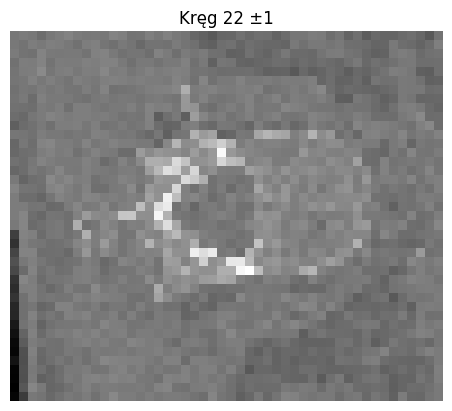

In [48]:
import matplotlib.pyplot as plt
import numpy as np

ordered_vertebra_labels = [
    41, 40, 39, 38, 37, 36, 35,  # C1–C7
    34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23,  # Th1–Th12
    22, 21, 20, 19, 18  # L1–L5
]

def extract_patch_with_neighbors(segmentation, input_tensor, center_label, margin=5, neighbor_range=1):
    try:
        center_index = ordered_vertebra_labels.index(center_label)
    except ValueError:
        print(f"❌ Label {center_label} not in vertebral list.")
        return None

    neighbor_labels = ordered_vertebra_labels[
        max(0, center_index - neighbor_range) : center_index + neighbor_range + 1
    ]

    # Maska dla danego kręgu i sąsiadów
    mask = np.isin(segmentation, neighbor_labels).astype(np.uint8)

    coords = np.array(mask.nonzero())
    if coords.shape[1] == 0:
        print("⚠️ Brak voxeli w masce łączonej.")
        return None

    zmin, ymin, xmin = coords.min(axis=1)
    zmax, ymax, xmax = coords.max(axis=1)

    zmin = max(zmin - margin, 0)
    ymin = max(ymin - margin, 0)
    xmin = max(xmin - margin, 0)
    zmax = min(zmax + margin, segmentation.shape[0])
    ymax = min(ymax + margin, segmentation.shape[1])
    xmax = min(xmax + margin, segmentation.shape[2])

    # Wytnij z input_tensor: (1, 1, D, H, W)
    patch = input_tensor[:, :, zmin:zmax, ymin:ymax, xmin:xmax]
    patch_tensor = patch.squeeze().detach().cpu()  # (D, H, W)

    print(f"✅ Patch dla labelu {center_label} + sąsiadów: shape={patch_tensor.shape}")

    # Wizualizacja slice Z
    mid = patch_tensor.shape[2] // 2
    plt.imshow(patch_tensor[:, :, mid], cmap="gray")
    plt.title(f"Kręg {center_label} ±{neighbor_range}")
    plt.axis("off")
    plt.show()

    return patch_tensor

# Przykład: vertebrae_L1 → label 22
patch_L1 = extract_patch_with_neighbors(segmentation, input_tensor, center_label=22)


In [49]:
patch_L1.shape

torch.Size([41, 48, 59])

In [50]:
torch.save(patch_L1, "patch_L1.pt")

# V3

In [51]:
import os
import SimpleITK as sitk
import numpy as np
import torch  # lub import tensorflow as tf

def load_dicom_series_with_metadata(dicom_dir):
    """
    Wczytuje serię DICOM z folderu, zwraca tensor, opis serii oraz metadane.
    """
    # Znajdź wszystkie pliki DICOM w folderze
    reader = sitk.ImageSeriesReader()
    dicom_series = reader.GetGDCMSeriesFileNames(dicom_dir)
    if not dicom_series:
        raise ValueError(f"Nie znaleziono serii DICOM w folderze: {dicom_dir}")
    reader.SetFileNames(dicom_series)

    # Wczytaj serię DICOM jako obraz 3D
    image = reader.Execute()

    # Przekształć na NumPy array
    image_array = sitk.GetArrayFromImage(image)  # Shape: (z, y, x)

    # Konwersja na tensor (PyTorch)
    tensor = torch.tensor(image_array, dtype=torch.float32)  # Shape: (z, y, x)

    # Pobierz metadane z obrazu
    spacing = image.GetSpacing()  # Rozdzielczość voxelowa (x, y, z)
    direction = image.GetDirection()  # Orientacja
    origin = image.GetOrigin()  # Początek układu współrzędnych

    # Pobierz opis serii z pierwszego pliku
    first_file = dicom_series[0]
    file_reader = sitk.ImageFileReader()
    file_reader.SetFileName(first_file)
    file_reader.ReadImageInformation()
    series_description = file_reader.GetMetaData("0008|103e") if file_reader.HasMetaDataKey("0008|103e") else "Unknown"

    # Zwróć tensor, opis serii i metadane
    metadata = {
        "spacing": spacing,
        "direction": direction,
        "origin": origin
    }
    return tensor, series_description, metadata

# Przykład użycia
dicom_root_folder = "/media/mateusz/DATA/downloads/inz/MM M 62"
series_tensors = {}

for root, dirs, files in os.walk(dicom_root_folder):
    if files:  # Jeśli folder zawiera pliki
        try:
            tensor, series_description, metadata = load_dicom_series_with_metadata(root)
            series_tensors[series_description] = {"tensor": tensor, "metadata": metadata}
            print(f"Wczytano tensor o kształcie: {tensor.shape} dla serii: {series_description} z folderu: {root}")
            print(f"Metadane: {metadata}")
        except Exception as e:
            print(f"Błąd wczytywania DICOM z folderu {root}: {e}")

# Wybierz tensor zgodnie z priorytetami
selected_tensor = None
selected_description = None
selected_metadata = None

# 1. Szukaj serii "kosci"
for series_description, data in series_tensors.items():
    if "kosci" in series_description.lower():
        selected_tensor = data["tensor"]
        selected_metadata = data["metadata"]
        selected_description = series_description
        print(f"Wybrano tensor dla serii: {series_description} (priorytet: kosci)")
        break

# 2. Jeśli nie znaleziono "kosci", szukaj "miekkie"
if selected_tensor is None:
    for series_description, data in series_tensors.items():
        if "miekkie" in series_description.lower():
            selected_tensor = data["tensor"]
            selected_metadata = data["metadata"]
            selected_description = series_description
            print(f"Wybrano tensor dla serii: {series_description} (priorytet: miekkie)")
            break

# 3. Jeśli nie znaleziono "kosci" ani "miekkie", wybierz największy tensor
if selected_tensor is None:
    max_size = 0
    for series_description, data in series_tensors.items():
        tensor_size = data["tensor"].numel()  # Liczba elementów w tensorze
        if tensor_size > max_size:
            max_size = tensor_size
            selected_tensor = data["tensor"]
            selected_metadata = data["metadata"]
            selected_description = series_description
    if selected_tensor is not None:
        print(f"Wybrano największy tensor dla serii: {selected_description} (rozmiar: {max_size})")

# Sprawdź, czy wybrano tensor
if selected_tensor is None:
    print("Nie znaleziono odpowiedniego tensora.")
else:
    print(f"Kształt wybranego tensora: {selected_tensor.shape}")
    print(f"Metadane wybranego tensora: {selected_metadata}")

Błąd wczytywania DICOM z folderu /media/mateusz/DATA/downloads/inz/MM M 62: Nie znaleziono serii DICOM w folderze: /media/mateusz/DATA/downloads/inz/MM M 62
Wczytano tensor o kształcie: torch.Size([2, 512, 512]) dla serii:  z folderu: /media/mateusz/DATA/downloads/inz/MM M 62/S1000
Metadane: {'spacing': (0.9765625, 0.9765625, 353.5533905932738), 'direction': (0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0), 'origin': (0.0, -205.7, 500.1)}


GDCMSeriesFileNames (0x5de2d6d5d6d0): No Series can be found, make sure your restrictions are not too strong



Wczytano tensor o kształcie: torch.Size([859, 512, 512]) dla serii: MIEKKIE  z folderu: /media/mateusz/DATA/downloads/inz/MM M 62/S2010
Metadane: {'spacing': (0.48828125, 0.48828125, 0.45), 'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), 'origin': (-169.0, 71.3, 59.58)}
Wczytano tensor o kształcie: torch.Size([859, 512, 512]) dla serii: KOSCI, iDose (4) z folderu: /media/mateusz/DATA/downloads/inz/MM M 62/S2020
Metadane: {'spacing': (0.48828125, 0.48828125, 0.45), 'direction': (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), 'origin': (-169.0, 71.3, 59.58)}
Błąd wczytywania DICOM z folderu /media/mateusz/DATA/downloads/inz/MM M 62/S3010: Exception thrown in SimpleITK ImageSeriesReader_Execute: /tmp/SimpleITK-build/ITK-prefix/include/ITK-5.4/itkImageSeriesReader.hxx:351:
ITK ERROR: ImageSeriesReader(0x5de2d6d5d6d0): Size mismatch! The size of  /media/mateusz/DATA/downloads/inz/MM M 62/S3010/I40 is [650, 512, 1] and does not match the required size [512, 512, 1] from file /medi

In [52]:
selected_tensor.shape

torch.Size([859, 512, 512])

In [63]:
from monai.transforms import ScaleIntensityRanged, Compose, LoadImaged, EnsureChannelFirstd, Spacingd, Orientationd, NormalizeIntensityd, EnsureTyped, ScaleIntensityd

# Definicja transformacji
transforms = Compose([
    LoadImaged(keys=["image"]),  # Ładowanie obrazu
    EnsureTyped(keys=["image"]),  # Konwersja na typ zgodny z PyTorch/NumPy
    EnsureChannelFirstd(keys=["image"]),  # Upewnienie się, że kanały są na pierwszej osi
    Orientationd(keys=["image"], axcodes="RAS"),  # Ustawienie orientacji na RAS
    Spacingd(keys=["image"], pixdim=(1.5, 1.5, 1.5), mode="bilinear"),  # Resampling do zadanych wymiarów voxelowych
    NormalizeIntensityd(keys=["image"], nonzero=True),  # Normalizacja intensywności na podstawie wartości niezerowych
    ScaleIntensityd(keys=["image"], minv=-1.0, maxv=1.0)  # Skalowanie intensywności do zakresu [-1.0, 1.0]
])

In [27]:
def save_tensor_as_nrrd(tensor, file_path, metadata):
    """
    Zapisuje tensor jako plik NRRD z metadanymi.
    
    Args:
        tensor (torch.Tensor): Tensor do zapisania.
        file_path (str): Ścieżka do pliku wyjściowego (powinna kończyć się na .nrrd).
        metadata (dict): Metadane obrazu, zawierające klucze: 'spacing', 'direction', 'origin'.
    """
    # Konwersja tensora na NumPy array
    array = tensor.numpy()  # Shape: (z, y, x)
    
    # Konwersja NumPy array na SimpleITK Image
    image = sitk.GetImageFromArray(array)  # SimpleITK interpretuje dane jako (z, y, x)
    
    # Ustaw metadane
    if "spacing" in metadata:
        image.SetSpacing(metadata["spacing"])  # Rozdzielczość voxelowa (x, y, z)
    if "direction" in metadata:
        image.SetDirection(metadata["direction"])  # Orientacja
    if "origin" in metadata:
        image.SetOrigin(metadata["origin"])  # Początek układu współrzędnych
    
    # Zapis do pliku NRRD
    sitk.WriteImage(image, file_path)
    print(f"Tensor zapisany jako NRRD z metadanymi: {file_path}")

In [28]:
import tempfile

In [64]:
with tempfile.TemporaryDirectory() as temp_dir:
    temp_file = os.path.join(temp_dir, "output.nrrd")
    
    # Zapisz tensor jako plik NIfTI
    save_tensor_as_nrrd(selected_tensor, temp_file, selected_metadata)
    print(f"Tensor zapisany jako plik tymczasowy: {temp_file}")
    
    # Przygotuj dane wejściowe dla transformacji
    data = {"image": temp_file}
    
    # Zastosuj transformacje

    transformed_data = transforms(data)
    transformed_tensor = transformed_data["image"]


Tensor zapisany jako NRRD z metadanymi: /media/mateusz/DATA/tmp/tmp5mx6knxy/output.nrrd
Tensor zapisany jako plik tymczasowy: /media/mateusz/DATA/tmp/tmp5mx6knxy/output.nrrd


In [65]:
transformed_tensor.shape

torch.Size([1, 167, 167, 258])

In [66]:
input_tensor = transformed_tensor.unsqueeze(0).to("cpu")  # Dodaj wymiar wsadu

In [67]:
from monai.inferers import sliding_window_inference

model.eval().to("cpu")
with torch.no_grad():
    output = sliding_window_inference(
        inputs=input_tensor,
        roi_size=(96, 96, 96),  
        sw_batch_size=1,
        predictor=model,
        overlap=0.5,
        mode="gaussian"
    )

In [68]:
segmentation = output.argmax(dim=1).squeeze().cpu().numpy()  # shape: (D, H, W)

# Policz unikalne etykiety i ile ich jest
labels, counts = np.unique(segmentation, return_counts=True)

# Pokaż w formie słownika
label_counts = dict(zip(labels, counts))

# Posortowane i wypisane
for label, count in sorted(label_counts.items(), key=lambda x: -x[1]):
    print(f"Label {label:>2}: {count} voxeli")

Label  0: 5009939 voxeli
Label 100: 178589 voxeli
Label 101: 162969 voxeli
Label 55: 132877 voxeli
Label 104: 126696 voxeli
Label 91: 124515 voxeli
Label 95: 122271 voxeli
Label 94: 120448 voxeli
Label 102: 118065 voxeli
Label 90: 116881 voxeli
Label 103: 101203 voxeli
Label 92: 92973 voxeli
Label  5: 89445 voxeli
Label 57: 65493 voxeli
Label  2: 63942 voxeli
Label  3: 60933 voxeli
Label 96: 36365 voxeli
Label 97: 36083 voxeli
Label  1: 35994 voxeli
Label  7: 35510 voxeli
Label 10: 29236 voxeli
Label 89: 28782 voxeli
Label 18: 26632 voxeli
Label 88: 26174 voxeli
Label 19: 25633 voxeli
Label 20: 25427 voxeli
Label 99: 22563 voxeli
Label 56: 21973 voxeli
Label 21: 21367 voxeli
Label  8: 19422 voxeli
Label 23: 19108 voxeli
Label 22: 18741 voxeli
Label 53: 14317 voxeli
Label 24: 9827 voxeli
Label 54: 9381 voxeli
Label 51: 7720 voxeli
Label 98: 7180 voxeli
Label  9: 5334 voxeli
Label 52: 4388 voxeli
Label  4: 3870 voxeli
Label  6: 3281 voxeli
Label 69: 2838 voxeli
Label 68: 2668 voxeli
Labe

In [69]:
output.shape

torch.Size([1, 105, 167, 167, 258])

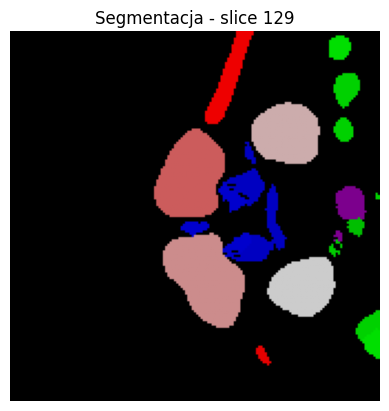

In [70]:
import matplotlib.pyplot as plt

# Załóżmy że output ma kształt (1, C, D, H, W)
output_np = output.argmax(dim=1).squeeze().cpu().numpy()  # (D, H, W)

z = output_np.shape[2] // 2  # środkowy slice

plt.imshow(output_np[:, :, z], cmap="nipy_spectral")
plt.title(f"Segmentacja - slice {z}")
plt.axis("off")
plt.show()

✅ Patch dla labelu 22 + sąsiadów: shape=torch.Size([74, 82, 112])


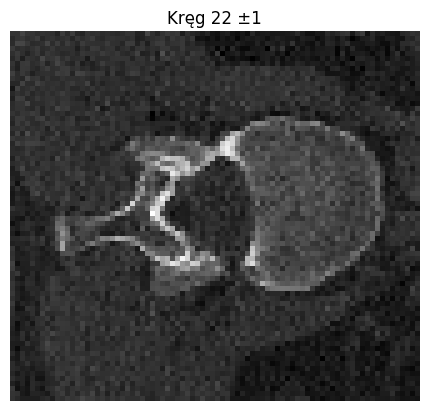

In [71]:
import matplotlib.pyplot as plt
import numpy as np

ordered_vertebra_labels = [
    41, 40, 39, 38, 37, 36, 35,  # C1–C7
    34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23,  # Th1–Th12
    22, 21, 20, 19, 18  # L1–L5
]

def extract_patch_with_neighbors(segmentation, input_tensor, center_label, margin=5, neighbor_range=1):
    try:
        center_index = ordered_vertebra_labels.index(center_label)
    except ValueError:
        print(f"❌ Label {center_label} not in vertebral list.")
        return None

    neighbor_labels = ordered_vertebra_labels[
        max(0, center_index - neighbor_range) : center_index + neighbor_range + 1
    ]

    # Maska dla danego kręgu i sąsiadów
    mask = np.isin(segmentation, neighbor_labels).astype(np.uint8)

    coords = np.array(mask.nonzero())
    if coords.shape[1] == 0:
        print("⚠️ Brak voxeli w masce łączonej.")
        return None

    zmin, ymin, xmin = coords.min(axis=1)
    zmax, ymax, xmax = coords.max(axis=1)

    zmin = max(zmin - margin, 0)
    ymin = max(ymin - margin, 0)
    xmin = max(xmin - margin, 0)
    zmax = min(zmax + margin, segmentation.shape[0])
    ymax = min(ymax + margin, segmentation.shape[1])
    xmax = min(xmax + margin, segmentation.shape[2])

    # Wytnij z input_tensor: (1, 1, D, H, W)
    patch = input_tensor[:, :, zmin:zmax, ymin:ymax, xmin:xmax]
    patch_tensor = patch.squeeze().detach().cpu()  # (D, H, W)

    print(f"✅ Patch dla labelu {center_label} + sąsiadów: shape={patch_tensor.shape}")

    # Wizualizacja slice Z
    mid = patch_tensor.shape[2] // 2
    plt.imshow(patch_tensor[:, :, mid], cmap="gray")
    plt.title(f"Kręg {center_label} ±{neighbor_range}")
    plt.axis("off")
    plt.show()

    return patch_tensor

# Przykład: vertebrae_L1 → label 22
patch_L1 = extract_patch_with_neighbors(segmentation, input_tensor, center_label=22)
